In [1]:
# Importing necessary lebraries
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as pl
import joblib
import seaborn as se
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import mlflow

In [2]:
sys.path.append(os.path.join(os.path.abspath('..')))
# Import modules
from src import data_loading as dl

In [3]:

sys.path.append(os.path.abspath("../"))


from scripts.model import prepare_data, split_data

from scripts.logger import logger 

In [4]:

credit = dl.load_data("creditcard.csv")


In [5]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:

duplicate_count = credit.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 1081


In [7]:
# Remove duplicates in the credit card data
credit = credit.drop_duplicates()
duplicate_count = credit.duplicated().sum()
print(f"Number of duplicate rows after drop duplicate : {duplicate_count}")

Number of duplicate rows after drop duplicate : 0


In [8]:
print('No frouds', round(credit['Class'].value_counts()[0]/len(credit) * 100,2),
      '% of the dataset')
print('Frouds', round(credit['Class'].value_counts()[1]/len(credit) * 100,2),
      '% of the dataset')

No frouds 99.83 % of the dataset
Frouds 0.17 % of the dataset


In [9]:
non_fraud_sum = credit[credit['Class'] == 0].value_counts().sum()
print(non_fraud_sum)

283253


In [10]:
fraud_sum = credit[credit['Class'] == 1].value_counts().sum()
print(fraud_sum)

473


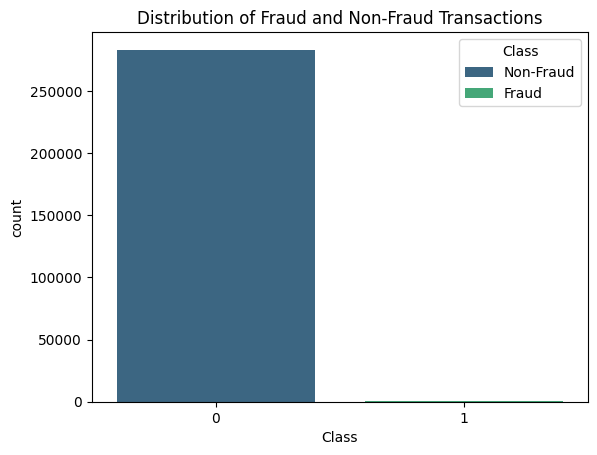

In [11]:
se.countplot(data=credit, x='Class', hue='Class', palette='viridis')
pl.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='best')
pl.title('Distribution of Fraud and Non-Fraud Transactions')
pl.show()

dataset is highly imbalanced, with a very small percentage of fraudulent transactions compared to non-fraudulent ones.class imbalance can affect the performance of machine learning models. Models might become biased towards the majority class (non-fraudulent transactions), leading to poor detection of the minority class (fraudulent transactions)

To address the class imbalance issue, we'll undersample the majority class
Shuffle Dataset: Randomly shuffles the dataset to ensure randomness.

Isolate Minority Class (Fraud): Selects all fraud instances (473).

Sample Majority Class (Non-Fraud): Randomly selects 473 non-fraud instances to match the number of fraud cases.

Create Balanced Dataset: Combines the fraud and selected non-fraud instances, then shuffles the combined dataset to ensure randomness.

In [12]:

# to match the number of instances in the minority class.

# Randomly shuffle the entire dataset to ensure randomness
df = credit.sample(frac=1, random_state=42).reset_index(drop=True)

# Isolate the minority class (fraud) with 473 instances
minority_class = df.loc[df['Class'] == 1]

# Select a random subset of the majority class (non-fraud) with the same number of instances as the minority class
majority_class_subset = df.loc[df['Class'] == 0].sample(n=473, random_state=42)

# Combine the minority class and the majority class subset to create a balanced dataset
balanced_df = pd.concat([minority_class, majority_class_subset])

# Shuffle the balanced dataset to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the first few rows of the balanced dataset
balanced_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,14073.0,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,...,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,1.00,1
1,55279.0,-5.753852,0.577610,-6.312782,5.159401,-1.698320,-2.683286,-7.934389,2.373550,-3.073079,...,1.177852,0.175331,-1.211123,-0.446891,-0.405520,-0.165797,1.505516,0.359492,1.00,1
2,45278.0,1.257581,0.389792,0.316394,0.688601,-0.329816,-1.062477,0.117713,-0.230186,-0.037977,...,-0.282539,-0.791483,0.124223,0.358095,0.232011,0.092895,-0.019934,0.031739,1.29,0
3,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
4,146022.0,0.908637,2.849024,-5.647343,6.009415,0.216656,-2.397014,-1.819308,0.338527,-2.819883,...,0.407260,-0.397435,-0.080006,-0.168597,0.465058,0.210510,0.648705,0.360224,1.18,1


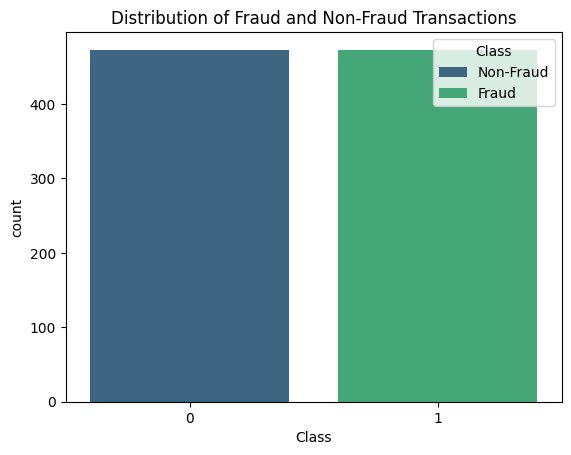

In [13]:
se.countplot(data=balanced_df, x='Class', hue='Class', palette='viridis')
pl.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='best')
pl.title('Distribution of Fraud and Non-Fraud Transactions')
pl.show()

In [14]:

X_credit, y_credit = prepare_data(balanced_df, 'Class')

INFO:fraud_detection_logger:Preparing data by separating features and target column: Class


2025-02-10 21:25:43,061 - INFO - Preparing data by separating features and target column: Class


In [15]:
# Convert target variable to integer
y = df.iloc[:, 20].astype(int).values  # Ensure `y` is categorical

# Define resampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.1)

# Apply under-sampling first
X_under, y_under = under.fit_resample(X, y)

# Apply over-sampling on the under-sampled data
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

# Now you can use the resampled data for further processing
print(Counter(y_resampled))


NameError: name 'X' is not defined